In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score
import random
random.seed(42)
import numpy as np
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
import torch
import gc
# Clear cache

# For debugging purposes, check memory stats
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")
torch.cuda.empty_cache()
gc.collect()
llama3_model_path = "meta-llama/Llama-3.2-1B"
file_path = "../../datasets_ready/Lexical.csv"
example_file_path = "../sample_data/llama3_sample_dataset.csv"
checkpoint_dir = "../results/checkpoint-4900"
SAMPLE_SIZE = 9760
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 5
BATCH_SIZE = 16


def create_input_text(row):
    return (
        f"""You are a member of the IELTS essay evaluation committee.\nYour task is to evaluate the essay based on the given prompt and assign it a score
        between 4 and 9 (in 1 point increments). 4 and 9 are the lowest and highest scores possible.
        Prompt contain the topic of the essay. Evaluate this essay in terms of lexical resources.
        Think step by step why this essay is good or bad. Evaluation section contains Human Evaluator's comments and marks which are offical results. Take their comment and marks into account
        when you provide your score.
        "Prompt: {row['prompt']}\nEssay: {row['essay']}\nComments: {row['text']}"""
    )

def map_band_to_class(band):
    if band ==  "<4":
        return band_to_class['<4']
    return band_to_class[str(band)]

band_classes = ['<4'] + ['4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5', '9'] 
# class_to_band = {i: band for band, i in band_to_class.items()}  # Class → Band

band_to_class = {
    '<4': 0, '4': 0,
    '4.5': 1, '5': 1,
    '5.5': 2, '6': 2,
    '6.5': 3, '7': 3,
    '7.5': 4, '8': 4,
    '8.5': 5, '9': 5
}

# Map bands to classes
def map_band_to_class(band):
    if band ==  "<4":
        return band_to_class['<4']
    return band_to_class[str(band)]

def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


: 

### Prepare Test Dataset

#### Prepare Model and Tokenizer, Move them to CUDA.

In [3]:
data = pd.read_csv(file_path).sample(n=SAMPLE_SIZE, random_state=42)
data['input_text'] = data.apply(create_input_text, axis=1)
data['labels'] = data['band'].apply(map_band_to_class)
# Drop unnecessary columns. Might need them later
data = data.drop(columns=["evaluation", "band", "prompt", "essay"])

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Prepare datasets for Hugging Face Trainer
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

print(f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}")

tokenizer = AutoTokenizer.from_pretrained(llama3_model_path)
tokenizer.pad_token = tokenizer.eos_token

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
print(f"train_dataset columns: {train_dataset.column_names}")
print(f"train_dataset[0]: {train_dataset[0]},\ntrain_dataset['labels'][0]: {train_dataset['labels'][0]}")

Train dataset length: 7840, Test dataset length: 1960


Map:   0%|          | 0/7840 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

train_dataset columns: ['input_text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']
train_dataset[0]: {'input_text': 'You are a member of the IELTS essay evaluation committee.\nYour task is to evaluate the essay based on the given prompt and assign it a score\n        between 4 and 9 (in 1 point increments). 4 and 9 are the lowest and highest scores possible.\n        Prompt contain the topic of the essay. The essay is the text that you need to evaluate.\n        Think step by step why this essay is good or bad. Evaluation section contains Human Evaluator\'s comments and marks which are offical results. Take their comment and marks into account\n        when you provide your score.\n        "Prompt: You can get up-to-date news from the radio, TV and the Internet. Which kind of media do you think is the best to get the news?\nEssay: Nowadays, there are several channels to get news, such as the radio, TV, newspapers and the Internet. I think the Internet is the best among

In [4]:
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e9 :.2f} GB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e9 :.2f} GB")
torch.cuda.empty_cache()
gc.collect()

Memory Allocated: 0.00 GB
Memory Reserved: 0.00 GB


72

## Setting up Trainer

In [5]:
num_labels = 6  # Total number of unique band scores
# C:\Users\26597\.cache\huggingface\hub Models are here
model_path = "andrijdavid/Llama-3-1B-Base"
llama3_model_path = "meta-llama/Llama-3.2-1B"

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_dir,
    num_labels=num_labels,
)
t = model.config.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Freeze the base model
for param in model.base_model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Device: {device}")

Device: cuda


In [6]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    # fp16=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    save_total_limit=1,
    load_best_model_at_end=True,
)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    qwk = cohen_kappa_score(labels, preds, weights="quadratic")
    return {
        "accuracy": acc,
        "QWK": qwk,
    }
    
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# Fine-tune the model
trainer.train()

# Evaluate on the test dataset
test_results = trainer.evaluate()
print(f"Test Results: {test_results}")


  0%|          | 0/4900 [00:00<?, ?it/s]

c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\transformers\models\llama\modeling_llama.py:602: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.9445613622665405, 'eval_accuracy': 0.2642857142857143, 'eval_QWK': 0.2226959898777875, 'eval_runtime': 519.2157, 'eval_samples_per_second': 3.775, 'eval_steps_per_second': 0.237, 'epoch': 1.0}
{'loss': 2.0356, 'grad_norm': 27.359590530395508, 'learning_rate': 8.979591836734695e-06, 'epoch': 1.02}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8977700471878052, 'eval_accuracy': 0.26071428571428573, 'eval_QWK': 0.23036321735895948, 'eval_runtime': 516.0746, 'eval_samples_per_second': 3.798, 'eval_steps_per_second': 0.238, 'epoch': 2.0}
{'loss': 1.9341, 'grad_norm': 22.19253921508789, 'learning_rate': 7.959183673469388e-06, 'epoch': 2.04}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8734079599380493, 'eval_accuracy': 0.2673469387755102, 'eval_QWK': 0.24330374060281124, 'eval_runtime': 516.3532, 'eval_samples_per_second': 3.796, 'eval_steps_per_second': 0.238, 'epoch': 3.0}
{'loss': 1.8931, 'grad_norm': 23.143054962158203, 'learning_rate': 6.938775510204082e-06, 'epoch': 3.06}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8581061363220215, 'eval_accuracy': 0.27448979591836736, 'eval_QWK': 0.25963341256166206, 'eval_runtime': 516.2321, 'eval_samples_per_second': 3.797, 'eval_steps_per_second': 0.238, 'epoch': 4.0}
{'loss': 1.8642, 'grad_norm': 20.394285202026367, 'learning_rate': 5.918367346938776e-06, 'epoch': 4.08}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8435930013656616, 'eval_accuracy': 0.27193877551020407, 'eval_QWK': 0.2636225777877351, 'eval_runtime': 469.8764, 'eval_samples_per_second': 4.171, 'eval_steps_per_second': 0.262, 'epoch': 5.0}
{'loss': 1.8366, 'grad_norm': 21.139989852905273, 'learning_rate': 4.897959183673469e-06, 'epoch': 5.1}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.835950493812561, 'eval_accuracy': 0.2739795918367347, 'eval_QWK': 0.2673708411187804, 'eval_runtime': 469.9179, 'eval_samples_per_second': 4.171, 'eval_steps_per_second': 0.262, 'epoch': 6.0}
{'loss': 1.8314, 'grad_norm': 25.06340789794922, 'learning_rate': 3.877551020408164e-06, 'epoch': 6.12}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8320401906967163, 'eval_accuracy': 0.2729591836734694, 'eval_QWK': 0.27019300019641923, 'eval_runtime': 470.0287, 'eval_samples_per_second': 4.17, 'eval_steps_per_second': 0.262, 'epoch': 7.0}
{'loss': 1.815, 'grad_norm': 22.38054656982422, 'learning_rate': 2.8571428571428573e-06, 'epoch': 7.14}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8257423639297485, 'eval_accuracy': 0.27653061224489794, 'eval_QWK': 0.27651705753967637, 'eval_runtime': 470.3081, 'eval_samples_per_second': 4.167, 'eval_steps_per_second': 0.262, 'epoch': 8.0}
{'loss': 1.8068, 'grad_norm': 26.957624435424805, 'learning_rate': 1.8367346938775512e-06, 'epoch': 8.16}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.8240431547164917, 'eval_accuracy': 0.27653061224489794, 'eval_QWK': 0.2818332837629034, 'eval_runtime': 469.4621, 'eval_samples_per_second': 4.175, 'eval_steps_per_second': 0.262, 'epoch': 9.0}
{'loss': 1.8018, 'grad_norm': 19.373668670654297, 'learning_rate': 8.163265306122449e-07, 'epoch': 9.18}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.823522925376892, 'eval_accuracy': 0.27653061224489794, 'eval_QWK': 0.28181029496818966, 'eval_runtime': 470.3304, 'eval_samples_per_second': 4.167, 'eval_steps_per_second': 0.262, 'epoch': 10.0}
{'train_runtime': 24870.1204, 'train_samples_per_second': 3.152, 'train_steps_per_second': 0.197, 'train_loss': 1.862398345324458, 'epoch': 10.0}


  0%|          | 0/123 [00:00<?, ?it/s]

Test Results: {'eval_loss': 1.823522925376892, 'eval_accuracy': 0.27653061224489794, 'eval_QWK': 0.28181029496818966, 'eval_runtime': 470.3259, 'eval_samples_per_second': 4.167, 'eval_steps_per_second': 0.262, 'epoch': 10.0}


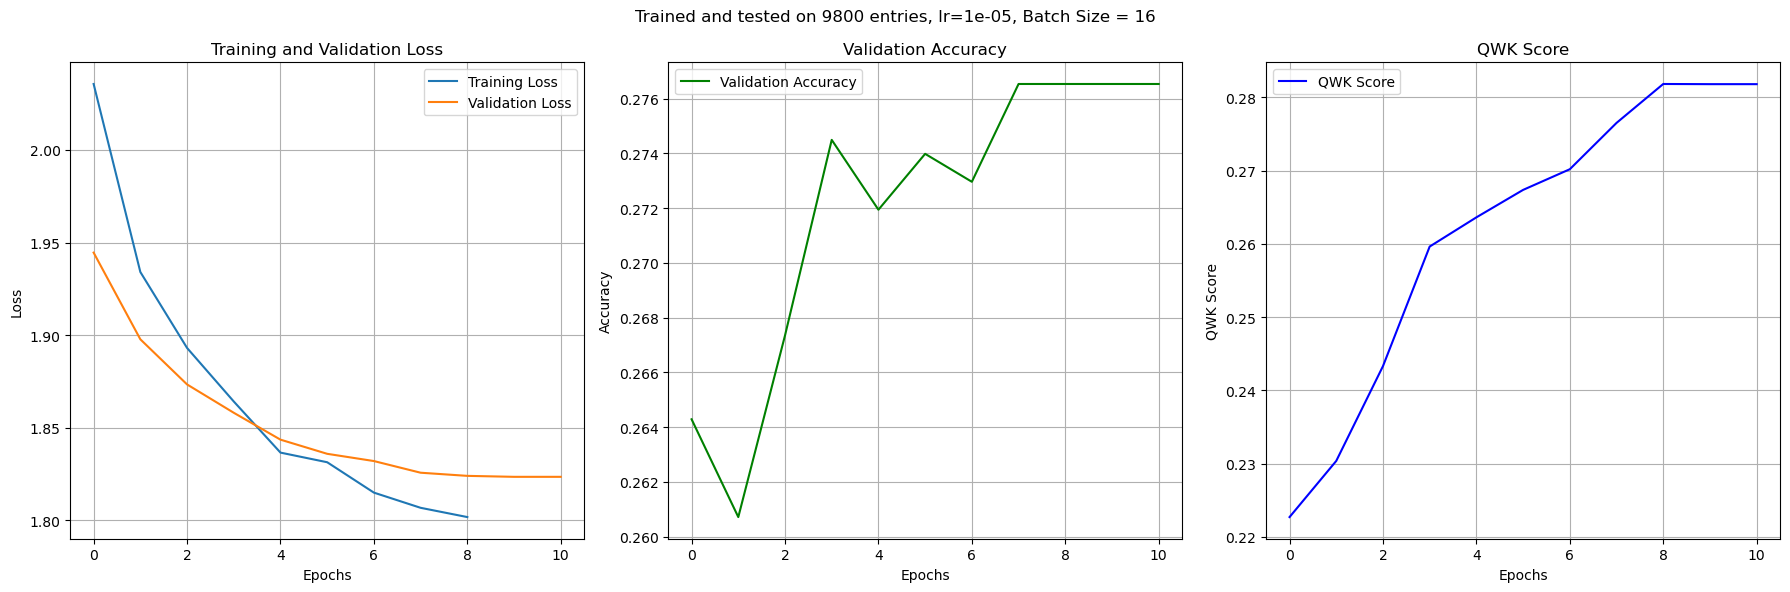

In [7]:
# After training
log_history = trainer.state.log_history

# Extract training and validation loss
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
qwk = [entry["eval_QWK"] for entry in log_history if "eval_QWK" in entry]

# Extract accuracy (if available in compute_metrics)
eval_accuracy = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot training and validation loss
axes[0].plot(train_loss, label="Training Loss")
axes[0].plot(eval_loss, label="Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid()

# Plot validation accuracy (if available)
if eval_accuracy:
    axes[1].plot(eval_accuracy, label="Validation Accuracy", color="green")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation Accuracy")
    axes[1].legend()
    axes[1].grid()

if qwk:
    axes[2].plot(qwk, label="QWK Score", color="blue")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("QWK Score")
    axes[2].set_title("QWK Score")
    axes[2].legend()
    axes[2].grid()

fig.suptitle(f"Trained and tested on {SAMPLE_SIZE} entries, lr={LEARNING_RATE}, Batch Size = {BATCH_SIZE}", fontsize=12)
plt.tight_layout()
plt.show()
